In [ ]:
!pip install pandas plotly matplotlib

In [ ]:
from experiment_helpers import *

In [ ]:
EXPERIMENT_TYPES = [
    "linux_prefetching_asyncwrites",
    "tape_prefetching_asyncwrites",
]
WORKLOADS = ["python","mmult_eigen","mmult_eigen_par_2", "mmult_eigen_par_3", 
             "mmult_eigen_vec", "mmult_eigen_dot", "sparse_eigen"]

In [ ]:
datas = []
for i in range(4):
    data = {}
    for workload in WORKLOADS:
        data[workload] = augment_tables(get_experiment_data(EXPERIMENT_TYPES, workload,"./%dswitch" % i), 
                                        filter_raw=True)
    datas.append(data)        

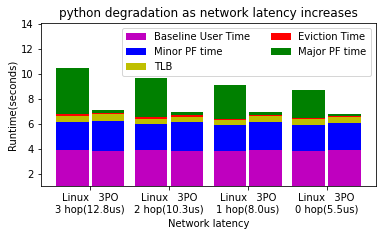

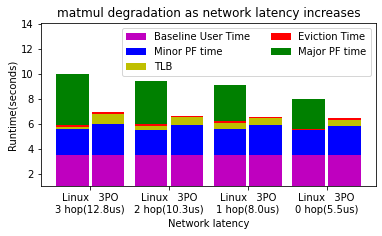

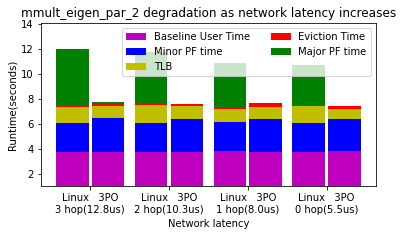

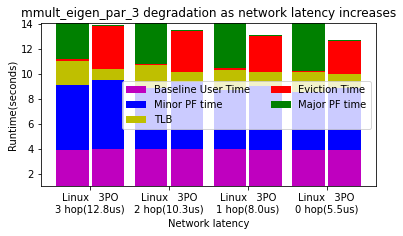

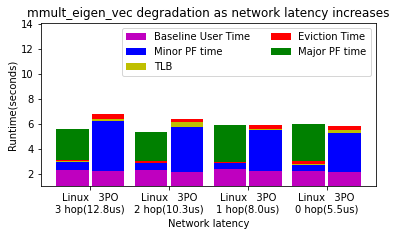

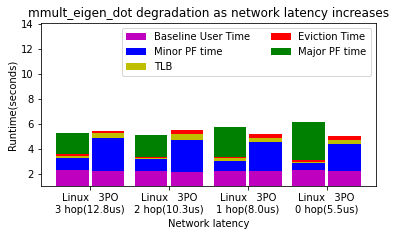

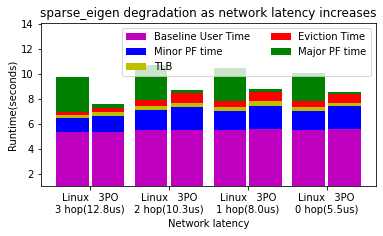

In [57]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'png'

# For recent conferences, I've had HotCRP complain about missing fonts unless I include this line
matplotlib.rcParams['pdf.fonttype'] = 42

for workload in WORKLOADS:
    plt.figure(figsize = (6, 3))

    i = -.5
    x_locs = []
    for data in reversed(datas):
        table = data[workload]

        sub_tbl = table[["Eviction Time",
                         "Baseline minor PF Time",
                         "Extra Minor PF Time",
                         "Major PF Time",
                         "Baseline User Time",
                         "Extra User Time",
                                         ]] / 1e6
        sub_tbl["Experiment Name"] = table["Experiment Name"]

        width = 0.1

        for exp in EXPERIMENT_TYPES:
            RATIO = 30
            t = sub_tbl[(sub_tbl.index == RATIO) & (sub_tbl["Experiment Name"] == exp)]
            y1 = t["Baseline User Time"]
            y2 = (t["Baseline minor PF Time"].values + sub_tbl["Extra Minor PF Time"].values)[0]
            y3 = t["Extra User Time"]
            y4 = 0
            y4 = t["Eviction Time"]
            y5 = t["Major PF Time"]

            x = i*0.11
            i+=1
            x_locs.append(x)
            plt.bar(x, y1, width=width, color='m')
            plt.bar(x, y2, width=width, bottom=y1, color='b')
            plt.bar(x, y3, width=width, bottom=y1+y2, color='y')
            plt.bar(x, y4, width=width, bottom=y1+y2+y3, color='r')
            plt.bar(x, y5, width=width, bottom=y1+y2+y3+y4, color='g')
        i += 0.21
        
    if workload == "mmult_eigen":
        workload = "matmul"

    plt.title("%s degradation as network latency increases" % workload)
    plt.ylim(bottom = 1, top = 14.1)
    plt.ylabel("Runtime(seconds)")
    plt.xlabel("Network latency")
    x_locs_avg = []
    for i in range(len(x_locs)-1):
        if i % 2 != 0:
            continue
        x_locs_avg.append((x_locs[i]+x_locs[i+1])/2)

#         5.5 8.0 10.3 12.8 15.3 17.6 
    plt.xticks(x_locs_avg, ["Linux   3PO\n3 hop(12.8us)", "Linux   3PO\n2 hop(10.3us)", "Linux   3PO\n1 hop(8.0us)", "Linux   3PO\n0 hop(5.5us)"])
    plt.legend(["Baseline User Time", "Minor PF time", "TLB",
                "Eviction Time",
                "Major PF time"], ncol=2)
    plt.show()